<a href="https://colab.research.google.com/github/AditiAmbasta13/Idea-Hackathon/blob/main/Union_Bank_GenAI_Personalized_Recommendations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install google-generativeai

Generating sample data...
Preprocessing data...
Segmenting customers...
Visualizing customer segments...


<ipython-input-13-b7b0af181a94>:491: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='cluster_name', y='travel_spend', data=customer_features, ax=axes[0, 1], palette='viridis')
<ipython-input-13-b7b0af181a94>:498: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='cluster_name', y='countries_visited', data=customer_features, ax=axes[1, 0], palette='viridis')
<ipython-input-13-b7b0af181a94>:505: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='cluster_name', y='travel_spend_pct', data=customer_features, ax=axes[1, 1], palette='viridis')


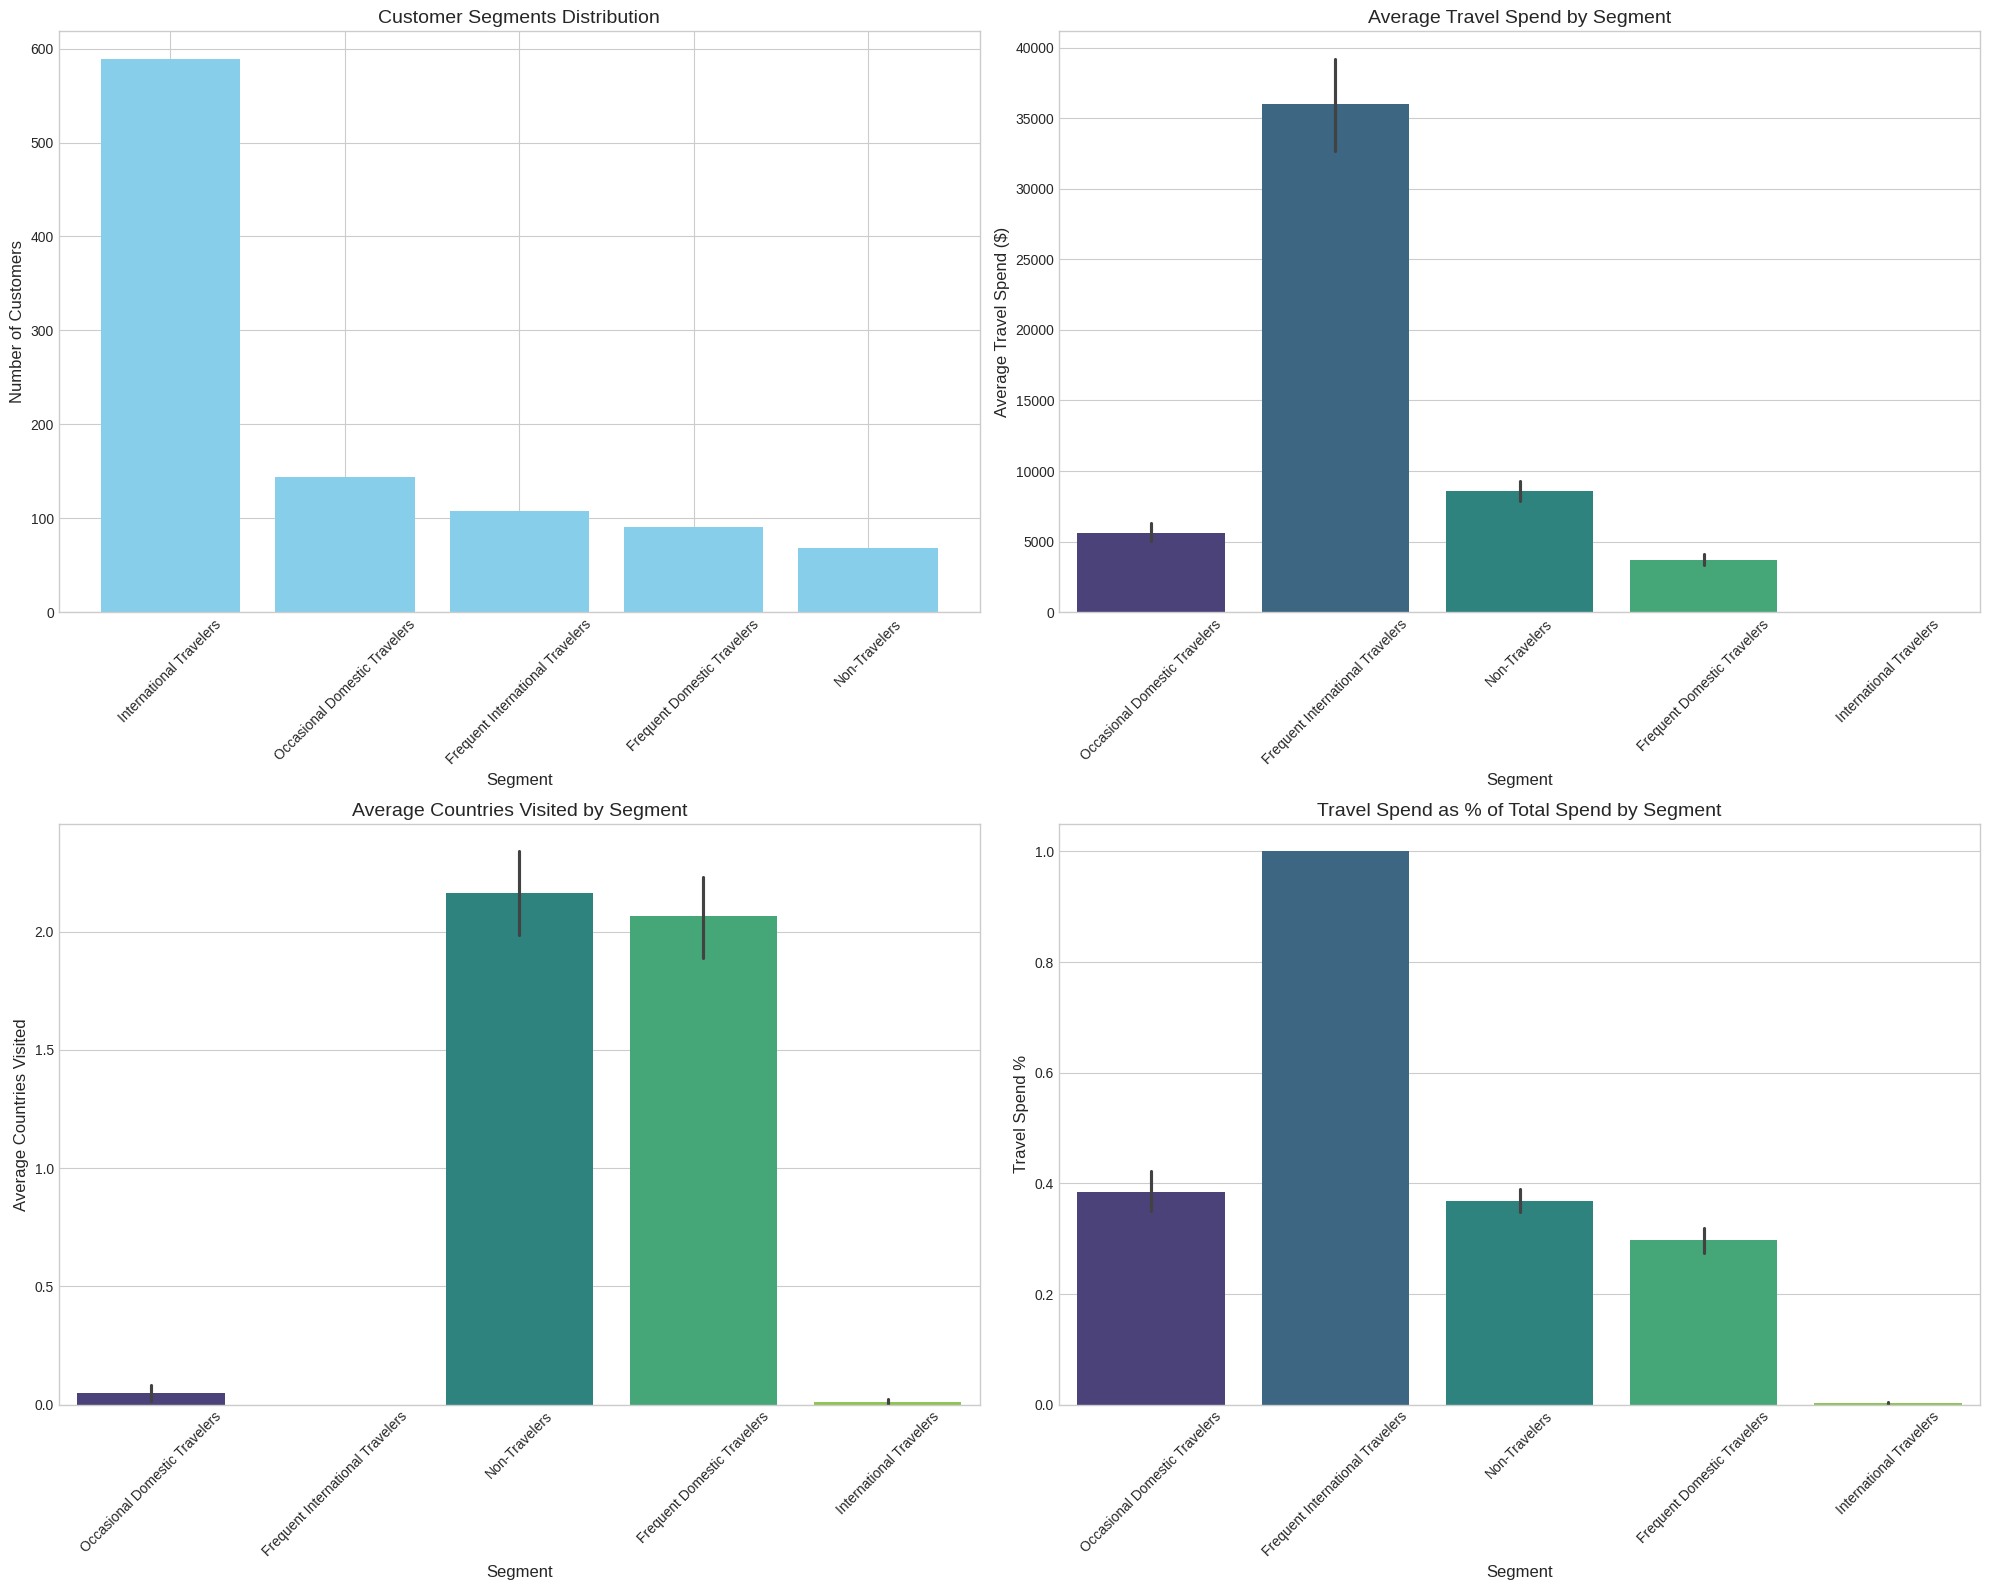

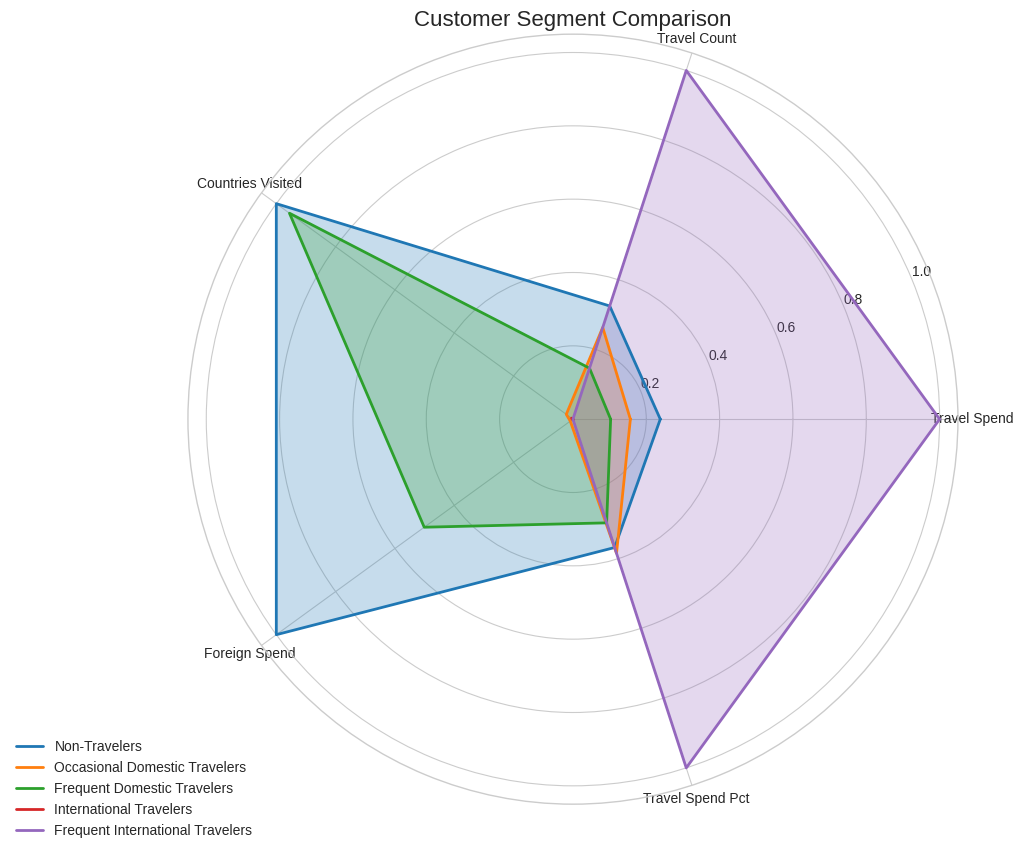

Generating personalized recommendations...
Selected sample customer: C0015

Personalized Recommendation:
{
  "recommended_products": [
    {
      "name": "Union Bank Travel Rewards Credit Card",
      "description": "A credit card designed for travelers with no foreign transaction fees, travel rewards points, and travel insurance benefits."
    },
    {
      "name": "Union Bank Premium Checking Account with Travel Perks",
      "description": "A checking account offering travel benefits such as airport lounge access and preferred foreign exchange rates."
    }
  ],
  "rationale": "While categorized as an 'International Traveler,' this customer's transaction history indicates no recent travel activity.  Therefore, the focus is on encouraging future travel by offering products that minimize upfront travel costs (no foreign transaction fees) and provide valuable travel benefits to incentivize usage.  The combination of a travel rewards credit card and a premium checking account with tra

Batch recommendations generated for 5 customers
Recommendations saved to 'union_bank_travel_recommendations.json'


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
import datetime
from google.colab import auth
import vertexai
from vertexai.generative_models import GenerativeModel
import re
import json
import google.generativeai as genai

np.random.seed(42)

# SAMPLE DATA GENERATION

def generate_sample_data(num_customers=1000):
    """Generate synthetic customer transaction data for demonstration purposes"""

    customer_ids = [f'C{i:04d}' for i in range(1, num_customers + 1)]

    ages = np.random.randint(18, 75, size=num_customers)
    genders = np.random.choice(['M', 'F'], size=num_customers)
    income_levels = np.random.choice(['Low', 'Medium', 'High', 'Very High'],
                                    size=num_customers,
                                    p=[0.2, 0.5, 0.2, 0.1])

    customer_data = pd.DataFrame({
        'customer_id': customer_ids,
        'age': ages,
        'gender': genders,
        'income_level': income_levels,
        'account_tenure_years': np.random.randint(1, 20, size=num_customers),
        'current_products': [np.random.choice(['Checking', 'Savings', 'Credit Card', 'Mortgage', 'Investment'],
                                              size=np.random.randint(1, 5),
                                              replace=False).tolist() for _ in range(num_customers)]
    })

    transactions = []

    current_date = datetime.datetime.now()

    traveler_ids = np.random.choice(customer_ids, size=int(num_customers * 0.3), replace=False)
    frequent_travelers = np.random.choice(traveler_ids, size=int(len(traveler_ids) * 0.4), replace=False)

    for customer_id in customer_ids:
        num_transactions = np.random.randint(20, 100)

        categories = ['Groceries', 'Dining', 'Shopping', 'Utilities', 'Entertainment']

        if customer_id in traveler_ids:
            categories.extend(['Airlines', 'Hotels', 'Car Rentals', 'Foreign Exchange'])

            is_international = np.random.random() > 0.5

            merchant_countries = ['USA']
            if is_international:
                additional_countries = np.random.choice(
                    ['Canada', 'Mexico', 'UK', 'France', 'Italy', 'Japan', 'Australia', 'Germany'],
                    size=np.random.randint(1, 4),
                    replace=False
                )
                merchant_countries.extend(additional_countries)
        else:
            merchant_countries = ['USA']

        for _ in range(num_transactions):
            days_ago = np.random.randint(1, 365)
            transaction_date = current_date - datetime.timedelta(days=days_ago)

            if customer_id in traveler_ids:
                if customer_id in frequent_travelers:
                    category = np.random.choice(categories, p=[0.2, 0.2, 0.2, 0.1, 0.1, 0.05, 0.05, 0.05, 0.05])
                else:
                    category = np.random.choice(categories, p=[0.25, 0.25, 0.25, 0.1, 0.05, 0.025, 0.025, 0.025, 0.025])

                if category in ['Airlines', 'Hotels', 'Car Rentals']:
                    travel_start = transaction_date

                    if category == 'Airlines':
                        hotel_date = travel_start + datetime.timedelta(days=np.random.randint(0, 2))
                        hotel_amount = np.random.uniform(100, 500)
                        merchant_country = np.random.choice(merchant_countries)

                        transactions.append({
                            'customer_id': customer_id,
                            'transaction_date': hotel_date,
                            'amount': hotel_amount,
                            'category': 'Hotels',
                            'merchant_name': f"Hotel in {merchant_country}",
                            'merchant_country': merchant_country
                        })

                        if np.random.random() > 0.5:
                            car_date = travel_start + datetime.timedelta(days=np.random.randint(0, 2))
                            car_amount = np.random.uniform(50, 200)

                            transactions.append({
                                'customer_id': customer_id,
                                'transaction_date': car_date,
                                'amount': car_amount,
                                'category': 'Car Rentals',
                                'merchant_name': f"Car Rental in {merchant_country}",
                                'merchant_country': merchant_country
                            })

                    travel_days = np.random.randint(2, 8)
                    for day in range(travel_days):
                        trip_date = travel_start + datetime.timedelta(days=day)
                        for _ in range(np.random.randint(1, 4)):
                            merchant_country = np.random.choice(merchant_countries)
                            trip_amount = np.random.uniform(10, 100)
                            trip_category = np.random.choice(['Dining', 'Shopping', 'Entertainment'])

                            transactions.append({
                                'customer_id': customer_id,
                                'transaction_date': trip_date,
                                'amount': trip_amount,
                                'category': trip_category,
                                'merchant_name': f"{trip_category} in {merchant_country}",
                                'merchant_country': merchant_country
                            })

            if category == 'Groceries':
                amount = np.random.uniform(20, 200)
            elif category == 'Dining':
                amount = np.random.uniform(10, 100)
            elif category == 'Shopping':
                amount = np.random.uniform(20, 500)
            elif category == 'Utilities':
                amount = np.random.uniform(50, 300)
            elif category == 'Entertainment':
                amount = np.random.uniform(10, 100)
            elif category == 'Airlines':
                amount = np.random.uniform(200, 1500)
            elif category == 'Hotels':
                amount = np.random.uniform(100, 1000)
            elif category == 'Car Rentals':
                amount = np.random.uniform(50, 300)
            elif category == 'Foreign Exchange':
                amount = np.random.uniform(100, 1000)
            else:
                amount = np.random.uniform(10, 100)

            merchant_country = np.random.choice(merchant_countries)

            transactions.append({
                'customer_id': customer_id,
                'transaction_date': transaction_date,
                'amount': amount,
                'category': category,
                'merchant_name': f"{category} in {merchant_country}",
                'merchant_country': merchant_country
            })

    transactions_df = pd.DataFrame(transactions)

    return customer_data, transactions_df

# DATA PREPROCESSING AND FEATURE ENGINEERING

def preprocess_data(customer_data, transactions_df):
    """Preprocess the data and engineer features for the recommendation system"""

    transactions_df['transaction_date'] = pd.to_datetime(transactions_df['transaction_date'])

    transactions_df['transaction_month'] = transactions_df['transaction_date'].dt.month
    transactions_df['transaction_year'] = transactions_df['transaction_date'].dt.year
    transactions_df['transaction_day_of_week'] = transactions_df['transaction_date'].dt.dayofweek
    transactions_df['is_weekend'] = transactions_df['transaction_day_of_week'].isin([5, 6]).astype(int)

    travel_categories = ['Airlines', 'Hotels', 'Car Rentals', 'Foreign Exchange']

    customer_features = transactions_df.groupby('customer_id').agg({
        'amount': ['sum', 'mean', 'std', 'count'],
        'transaction_date': ['min', 'max']
    })

    customer_features.columns = ['_'.join(col).strip() for col in customer_features.columns.values]
    customer_features.reset_index(inplace=True)

    current_date = datetime.datetime.now()
    customer_features['recency_days'] = (current_date - customer_features['transaction_date_max']).dt.days

    customer_features['transaction_tenure_days'] = (customer_features['transaction_date_max'] -
                                                   customer_features['transaction_date_min']).dt.days

    travel_features = []

    for customer_id in customer_data['customer_id']:
        customer_txns = transactions_df[transactions_df['customer_id'] == customer_id]

        travel_txns = customer_txns[customer_txns['category'].isin(travel_categories)]
        foreign_txns = customer_txns[customer_txns['merchant_country'] != 'USA']

        countries_visited = foreign_txns['merchant_country'].nunique()

        travel_spend = travel_txns['amount'].sum() if not travel_txns.empty else 0
        travel_count = len(travel_txns)
        foreign_spend = foreign_txns['amount'].sum() if not foreign_txns.empty else 0
        foreign_count = len(foreign_txns)

        total_spend = customer_txns['amount'].sum()
        travel_spend_pct = (travel_spend / total_spend) if total_spend > 0 else 0

        recent_date = current_date - datetime.timedelta(days=60)
        recent_travel = len(travel_txns[travel_txns['transaction_date'] >= recent_date]) > 0

        if travel_count > 1:
            sorted_travel = travel_txns.sort_values('transaction_date')
            travel_gaps = sorted_travel['transaction_date'].diff().dropna()
            avg_travel_gap_days = travel_gaps.dt.days.mean()
        else:
            avg_travel_gap_days = 365

        travel_features.append({
            'customer_id': customer_id,
            'travel_spend': travel_spend,
            'travel_count': travel_count,
            'travel_spend_pct': travel_spend_pct,
            'foreign_spend': foreign_spend,
            'foreign_count': foreign_count,
            'countries_visited': countries_visited,
            'recent_travel': recent_travel,
            'avg_travel_gap_days': avg_travel_gap_days
        })

    travel_features_df = pd.DataFrame(travel_features)

    customer_features = pd.merge(customer_features, travel_features_df, on='customer_id')
    customer_features = pd.merge(customer_features, customer_data, on='customer_id')

    product_features = pd.DataFrame(customer_features['customer_id'])

    # Add product indicator columns
    all_products = ['Checking', 'Savings', 'Credit Card', 'Mortgage', 'Investment']
    for product in all_products:
        product_features[f'has_{product.lower().replace(" ", "_")}'] = customer_features['current_products'].apply(
            lambda x: 1 if product in x else 0
        )

    # Drop the original list column and merge back
    customer_features = customer_features.drop('current_products', axis=1)
    customer_features = pd.merge(customer_features, product_features, on='customer_id')

    return customer_features

# 4. CUSTOMER SEGMENTATION

def segment_customers(customer_features):
    """Segment customers based on their travel patterns and spending behavior"""

    # Select features for clustering
    cluster_features = [
        'travel_spend', 'travel_count', 'travel_spend_pct',
        'foreign_spend', 'foreign_count', 'countries_visited',
        'avg_travel_gap_days', 'amount_sum', 'amount_mean'
    ]

    # Prepare the data for clustering
    X = customer_features[cluster_features].copy()

    # Create preprocessor
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), cluster_features)
        ]
    )

    # Create clustering pipeline
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('kmeans', KMeans(n_clusters=5, random_state=42))
    ])

    # Fit the pipeline
    pipeline.fit(X)

    # Get cluster labels
    customer_features['cluster'] = pipeline.named_steps['kmeans'].labels_

    # Analyze the clusters
    cluster_analysis = customer_features.groupby('cluster').agg({
        'travel_spend': 'mean',
        'travel_count': 'mean',
        'travel_spend_pct': 'mean',
        'foreign_spend': 'mean',
        'foreign_count': 'mean',
        'countries_visited': 'mean',
        'avg_travel_gap_days': 'mean',
        'amount_sum': 'mean',
        'amount_mean': 'mean',
        'customer_id': 'count'
    }).reset_index()

    # Define cluster names based on characteristics
    cluster_names = {
        0: "Non-Travelers",      # Low travel metrics
        1: "Occasional Domestic Travelers",  # Moderate domestic travel
        2: "Frequent Domestic Travelers",    # High domestic travel
        3: "International Travelers",        # Some international travel
        4: "Frequent International Travelers"  # High international travel
    }

    # Map cluster numbers to names
    cluster_analysis['cluster_name'] = cluster_analysis['cluster'].map(cluster_names)
    customer_features['cluster_name'] = customer_features['cluster'].map(cluster_names)

    return customer_features, cluster_analysis


# 5. RECOMMENDATION ENGINE WITH GEMINI

def generate_product_recommendations(customer_features, customer_id):
    """Generate personalized product recommendations using Gemini API"""

    # Get customer data
    customer = customer_features[customer_features['customer_id'] == customer_id].iloc[0]

    # Extract relevant features for the recommendation
    customer_profile = {
        "customer_id": customer_id,
        "age": int(customer['age']),
        "gender": customer['gender'],
        "income_level": customer['income_level'],
        "account_tenure_years": int(customer['account_tenure_years']),
        "travel_metrics": {
            "travel_spend": float(customer['travel_spend']),
            "travel_count": int(customer['travel_count']),
            "travel_spend_percentage": float(customer['travel_spend_pct']),
            "foreign_spend": float(customer['foreign_spend']),
            "foreign_transactions": int(customer['foreign_count']),
            "countries_visited": int(customer['countries_visited']),
            "has_recent_travel": bool(customer['recent_travel']),
            "average_travel_gap_days": float(customer['avg_travel_gap_days'])
        },
        "financial_metrics": {
            "total_spend": float(customer['amount_sum']),
            "average_transaction": float(customer['amount_mean']),
            "transaction_count": int(customer['amount_count'])
        },
        "current_products": {
            "has_checking": bool(customer['has_checking']),
            "has_savings": bool(customer['has_savings']),
            "has_credit_card": bool(customer['has_credit_card']),
            "has_mortgage": bool(customer['has_mortgage']),
            "has_investment": bool(customer['has_investment'])
        },
        "segment": customer['cluster_name']
    }

    # Create prompt for Gemini
    prompt = f"""
    As an AI banking assistant for Union Bank, please analyze the following customer data and provide personalized product recommendations, focusing on travel-related financial products and services.

    Customer Profile:
    {json.dumps(customer_profile, indent=2)}

    Please provide:
    1. A personalized product recommendation (focus on travel-related financial products like credit cards, foreign exchange services, or travel insurance) based on the customer's transaction history and profile.
    2. A brief explanation of why this recommendation is suitable for the customer.
    3. Key benefits that would appeal to this customer.
    4. A personalized message that could be used in an email or app notification.

    Format your response as a JSON object with the following structure:
    {{
        "recommended_products": [list of recommended products with names and brief descriptions],
        "rationale": "explanation of why these products are recommended",
        "key_benefits": [list of benefits],
        "personalized_message": "customer-facing message"
    }}
    """

    try:
        # Set your Gemini API key
        genai.configure(api_key="Gemini_api_key")  # Replace with your actual API key

        # Initialize the Gemini model
        model = genai.GenerativeModel('gemini-1.5-pro-latest')

        # Generate recommendation
        response = model.generate_content(prompt)

        # Extract and parse the JSON response
        recommendation_text = response.text

        # Find JSON content (handle potential text before/after the JSON)
        json_match = re.search(r'({[\s\S]*})', recommendation_text)
        if json_match:
            recommendation_json = json.loads(json_match.group(1))
            return recommendation_json
        else:
            return {"error": "Failed to parse JSON response"}

    except Exception as e:
        return {"error": f"Error generating recommendation: {str(e)}"}

# 6. VISUALIZATION AND ANALYSIS

def visualize_customer_segments(customer_features, cluster_analysis):
    """Visualize customer segments and their characteristics"""

    # Set up the plot style
    plt.style.use('seaborn-v0_8-whitegrid')

    # Create a figure with subplots
    fig, axes = plt.subplots(2, 2, figsize=(20, 16))

    # Plot 1: Cluster sizes
    cluster_sizes = customer_features['cluster_name'].value_counts()
    axes[0, 0].bar(cluster_sizes.index, cluster_sizes.values, color='skyblue')
    axes[0, 0].set_title('Customer Segments Distribution', fontsize=14)
    axes[0, 0].set_xlabel('Segment', fontsize=12)
    axes[0, 0].set_ylabel('Number of Customers', fontsize=12)
    axes[0, 0].tick_params(axis='x', rotation=45)

    # Plot 2: Travel spend by cluster
    sns.barplot(x='cluster_name', y='travel_spend', data=customer_features, ax=axes[0, 1], palette='viridis')
    axes[0, 1].set_title('Average Travel Spend by Segment', fontsize=14)
    axes[0, 1].set_xlabel('Segment', fontsize=12)
    axes[0, 1].set_ylabel('Average Travel Spend ($)', fontsize=12)
    axes[0, 1].tick_params(axis='x', rotation=45)

    # Plot 3: Countries visited by cluster
    sns.barplot(x='cluster_name', y='countries_visited', data=customer_features, ax=axes[1, 0], palette='viridis')
    axes[1, 0].set_title('Average Countries Visited by Segment', fontsize=14)
    axes[1, 0].set_xlabel('Segment', fontsize=12)
    axes[1, 0].set_ylabel('Average Countries Visited', fontsize=12)
    axes[1, 0].tick_params(axis='x', rotation=45)

    # Plot 4: Travel spend percentage by cluster
    sns.barplot(x='cluster_name', y='travel_spend_pct', data=customer_features, ax=axes[1, 1], palette='viridis')
    axes[1, 1].set_title('Travel Spend as % of Total Spend by Segment', fontsize=14)
    axes[1, 1].set_xlabel('Segment', fontsize=12)
    axes[1, 1].set_ylabel('Travel Spend %', fontsize=12)
    axes[1, 1].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

    # Create a radar chart for cluster comparison
    cluster_metrics = ['travel_spend', 'travel_count', 'countries_visited',
                       'foreign_spend', 'travel_spend_pct']

    # Normalize the metrics for better comparison
    normalized_metrics = {}
    for metric in cluster_metrics:
        max_value = cluster_analysis[metric].max()
        if max_value > 0:  # Avoid division by zero
            normalized_metrics[metric] = cluster_analysis[metric] / max_value
        else:
            normalized_metrics[metric] = cluster_analysis[metric]

    # Create radar chart
    fig, ax = plt.subplots(figsize=(12, 10), subplot_kw=dict(polar=True))

    # Number of variables
    N = len(cluster_metrics)

    # Compute angle for each metric
    angles = [n / float(N) * 2 * np.pi for n in range(N)]
    angles += angles[:1]  # Close the loop

    # Plot each cluster
    for i, row in cluster_analysis.iterrows():
        values = [normalized_metrics[metric][i] for metric in cluster_metrics]
        values += values[:1]  # Close the loop

        ax.plot(angles, values, linewidth=2, label=row['cluster_name'])
        ax.fill(angles, values, alpha=0.25)

    # Set labels and title
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels([metric.replace('_', ' ').title() for metric in cluster_metrics])
    ax.set_title('Customer Segment Comparison', size=16)
    plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))

    plt.show()

# 7. MAIN EXECUTION

def main():
    # Step 1: Generate sample data
    print("Generating sample data...")
    customer_data, transactions_df = generate_sample_data(num_customers=1000)

    # Step 2: Preprocess data
    print("Preprocessing data...")
    customer_features = preprocess_data(customer_data, transactions_df)

    # Step 3: Segment customers
    print("Segmenting customers...")
    customer_features, cluster_analysis = segment_customers(customer_features)

    # Step 4: Visualize segments
    print("Visualizing customer segments...")
    visualize_customer_segments(customer_features, cluster_analysis)

    # Step 5: Generate recommendations for a sample customer
    print("Generating personalized recommendations...")

    # Select a sample customer from the "International Travelers" segment
    sample_customer = customer_features[customer_features['cluster_name'] == 'International Travelers'].iloc[0]
    sample_customer_id = sample_customer['customer_id']

    print(f"Selected sample customer: {sample_customer_id}")

    # Generate recommendation
    recommendation = generate_product_recommendations(customer_features, sample_customer_id)

    # Print recommendation
    print("\nPersonalized Recommendation:")
    print(json.dumps(recommendation, indent=2))

    # Step 6: Example of batch processing for multiple customers
    print("\nProcessing batch recommendations for high-value international travelers...")
    high_value_travelers = customer_features[
        (customer_features['cluster_name'] == 'Frequent International Travelers') &
        (customer_features['amount_sum'] > customer_features['amount_sum'].median())
    ]['customer_id'].tolist()[:5]  # Get top 5 for demonstration

    batch_recommendations = {}
    for cust_id in high_value_travelers:
        batch_recommendations[cust_id] = generate_product_recommendations(customer_features, cust_id)

    print(f"Batch recommendations generated for {len(batch_recommendations)} customers")

    # Save the generated recommendations to a file
    with open('union_bank_travel_recommendations.json', 'w') as f:
        json.dump(batch_recommendations, f, indent=2)

    print("Recommendations saved to 'union_bank_travel_recommendations.json'")

if __name__ == "__main__":
    main()

In [ ]:
import matplotlib.pyplot as plt
print(plt.style.available)

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'petroff10', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']
